# Análise da progressão de dados NULLs oriundos do INEP ao longo dos anos a partir da base do SIMCAQ

### O INEP realiza anualmente um censo educacional que alimenta grande parte da base de dados do SIMCAQ (Simulador Custo-Aluno Qualidade), uma plataforma divulga previsões orçamentárias para construir uma educação de qualidade dadas certas variáveis. A base do SIMCAQ acumula dados desde 2007 obtidos com censos feitos pelo INEP e outras fontes de dados abertos. As discrepâncias dos microdados são mapeadas ao longo dos anos a fim de tornar a base o mais constante possível, porém várias diferenças em relação a forma em que as pesquisas são divulgadas dificultam esse objetivo. Algumas diferenças estão na semântica do dado apresentado, na adição ou na remoção de microdados, o que transforma a base de dados do SIMCAQ. 
### O objetivo desse projeto é investigar como as mudanças da base do INEP influenciam na qualidade dos dados da base do SIMCAQ ao longo dos anos. O aspecto analisado será a quantidade de dados nulos e como sua variação ocorre ao longo dos anos.


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## 1) Leitura e tratamento dos dados

In [3]:
tabela = 'escola'
df = pd.read_csv(f'./statistics/{tabela}_null_statistics.csv', delimiter=';');
df.head()

colName     total  2007  2008  2009  2010  2011  2012  \
0         abre_final_de_semana  0.711755   1.0   1.0   1.0   1.0   1.0   1.0   
1      acessibilidade_corrimao  0.907787   1.0   1.0   1.0   1.0   1.0   1.0   
2      acessibilidade_elevador  0.907787   1.0   1.0   1.0   1.0   1.0   1.0   
3   acessibilidade_inexistente  0.861221   1.0   1.0   1.0   1.0   1.0   1.0   
4  acessibilidade_pisos_tateis  0.907787   1.0   1.0   1.0   1.0   1.0   1.0   

       2013      2014      2015      2016      2017      2018      2019  \
0  0.281497  0.300569  0.308821  0.327419  0.341537  0.357563  1.000000   
1  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
3  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  0.367055   
4  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

       2020      2021  
0  1.000000  1.000000  
1  0.191545  0.185778  
2  0.191545  0.185778  
3  0.191545  0.185778  
4  0.191545  0.185778

#### Os CSVs gerados contém a porcentagem de NULLs para cada coluna ao longo dos anos de uma tabela.

In [4]:
colNames = df.iloc[:,0:1].values
norm = df.drop(['colName'], axis='columns')
y = []
for col in colNames:
    y.append(col[0])

#### Nome das colunas separados para plotar o gráfico

In [5]:
norm = 1-norm
norm.head()
norm_com_nomes = norm.copy()
norm_com_nomes['colNames'] = colNames
norm_com_nomes.to_csv(f'./tabelas_normalizadas/{tabela}_normalizada.csv', sep=';')

#### Valores invertidos para facilitar a visualização dos dados. 1 significa que há 100% de dados preechidos e 0 significa que existem apenas dados nulos.

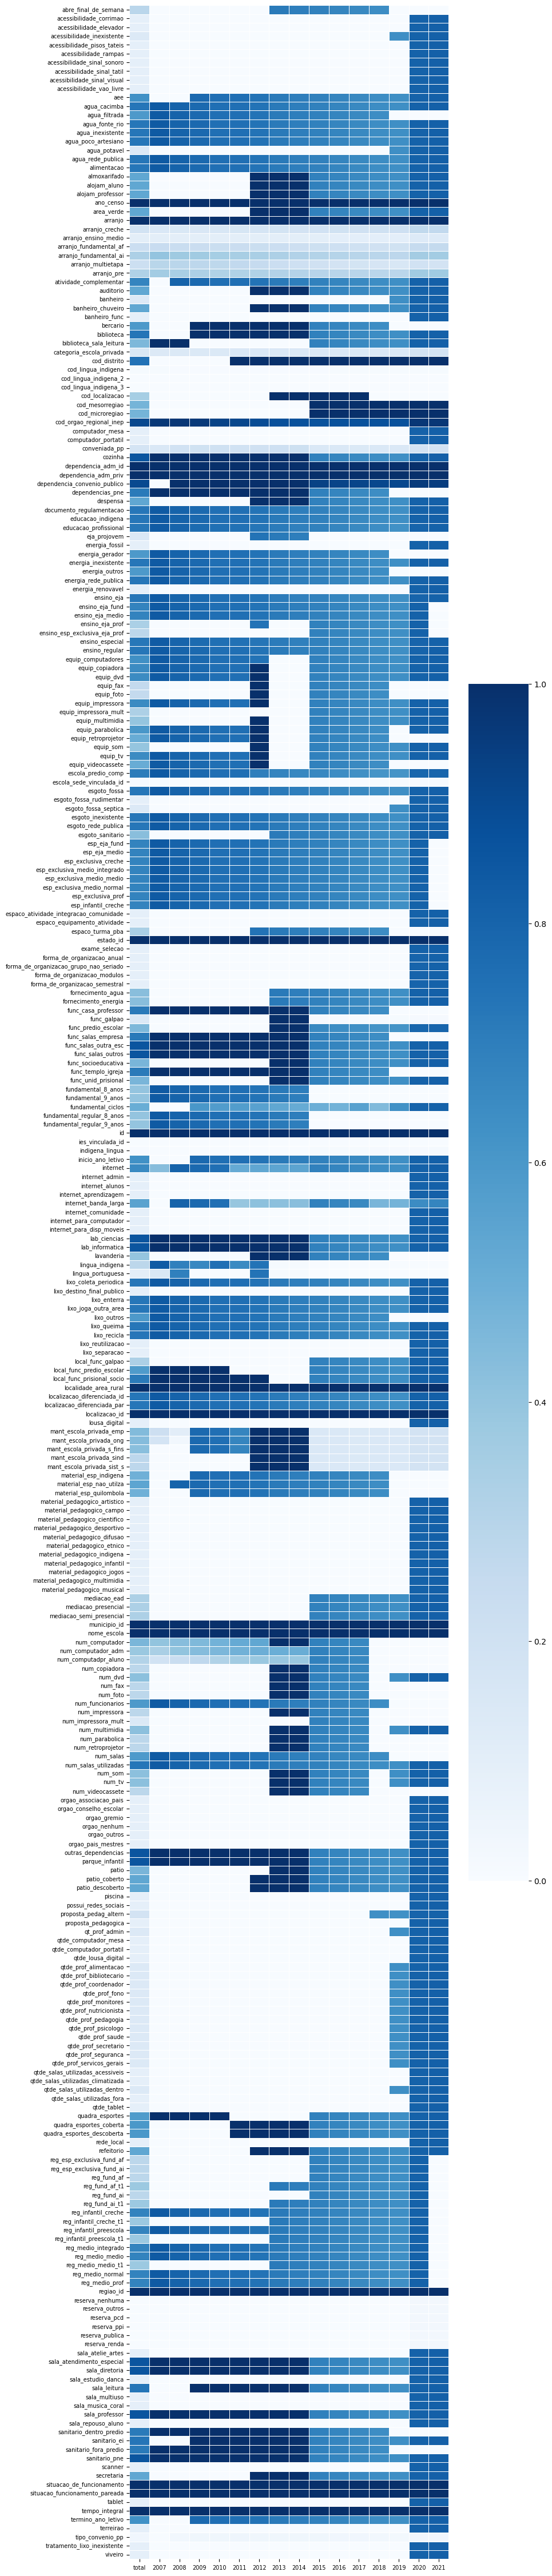

In [6]:
plt.figure(figsize=(9,int(len(norm)*0.2)))
plt.yticks(fontsize=7)
plt.xticks(fontsize=7)
sns.heatmap(norm, cmap='Blues', linewidths=0.5, yticklabels=y, annot_kws={'fontsize': 5}, annot=False)
plt.savefig(f'./save_figures/{tabela}_total.png')

## 2) Separar colunas de interesse para a análise

#### Para o objetivo dessa análise, há 2 tipos colunas de interesse: as que tinham dado e, por algum motivo, parou de de ser disponibilizado, e dados que gradualmente diminuíram ao longo dos anos.

#### 2.1) Para começar, removem-se as colunas totalmente preenchidas.

In [6]:
thresh_total = 0.85
y_interested = y.copy()
interested_df = norm[norm['total'] < thresh_total]
indexes_removed = norm[norm['total'] >= thresh_total].index
for index in reversed(indexes_removed):
    y_interested.pop(index)

#### 2.2) Agora, remove-se colunas que foram adicionadas ao longo dos anos a partir de um thresh

In [7]:
year_tresh = 3000
indexes_removed = []
for count, lin in enumerate(interested_df.index):
    seq = False
    added_column = True 
    for col in interested_df.drop(['total'], axis='columns').columns:
        # Se está contando uma sequência e ela para OU se não está contando uma sequência e começa a contar depois do thresh do ano então quebra o laço
        if(seq == True and interested_df[[col]].loc[lin].values[0] == 0.0 or seq == False and interested_df[[col]].loc[lin].values[0] != 0.0 and int(col) < year_tresh):
            added_column = False
            break
        # Começa a contar a sequência quando acha um valor diferente de 0
        if(seq == False and interested_df[[col]].loc[lin].values[0] != 0.0):
            seq = True
    if(added_column == True and interested_df[['2007']].loc[lin].values[0] == 0.0):
        interested_df = interested_df.drop(lin)
        indexes_removed.append(count)

# Remove da lista de colunas os ids excluídos
for index in reversed(indexes_removed):
    y_interested.pop(index)

#### 2.3) Por fim, removem-se as colunas com poucos dados.

In [8]:
thresh_total = 0.2
interested_df_t = interested_df.T
interested_df_final = interested_df.copy()
y_interested_final = y_interested.copy()
y_remove = []
# Remove colunas com uma porcentagem máxima menor que o thresh
for index, col in enumerate(interested_df_t):
    maximo = interested_df_t[col].max()
    if maximo < 0.20:
        print(f'{col} = {interested_df_t[col].max()}')
        interested_df_final = interested_df_final.drop(col)
        y_remove.append(index)

for index in reversed(y_remove):
    y_interested_final.pop(index)

7 = 0.10863160298027197
8 = 0.06436848876100398
9 = 0.055302006416801164
10 = 0.050393715109534054
11 = 0.03671021252113915
12 = 0.017208353022792777
13 = 0.028421667814689355
51 = 0.03052584651202117
60 = 0.029594176706662423
106 = 0.04819664144839042
110 = 0.08510107396927302


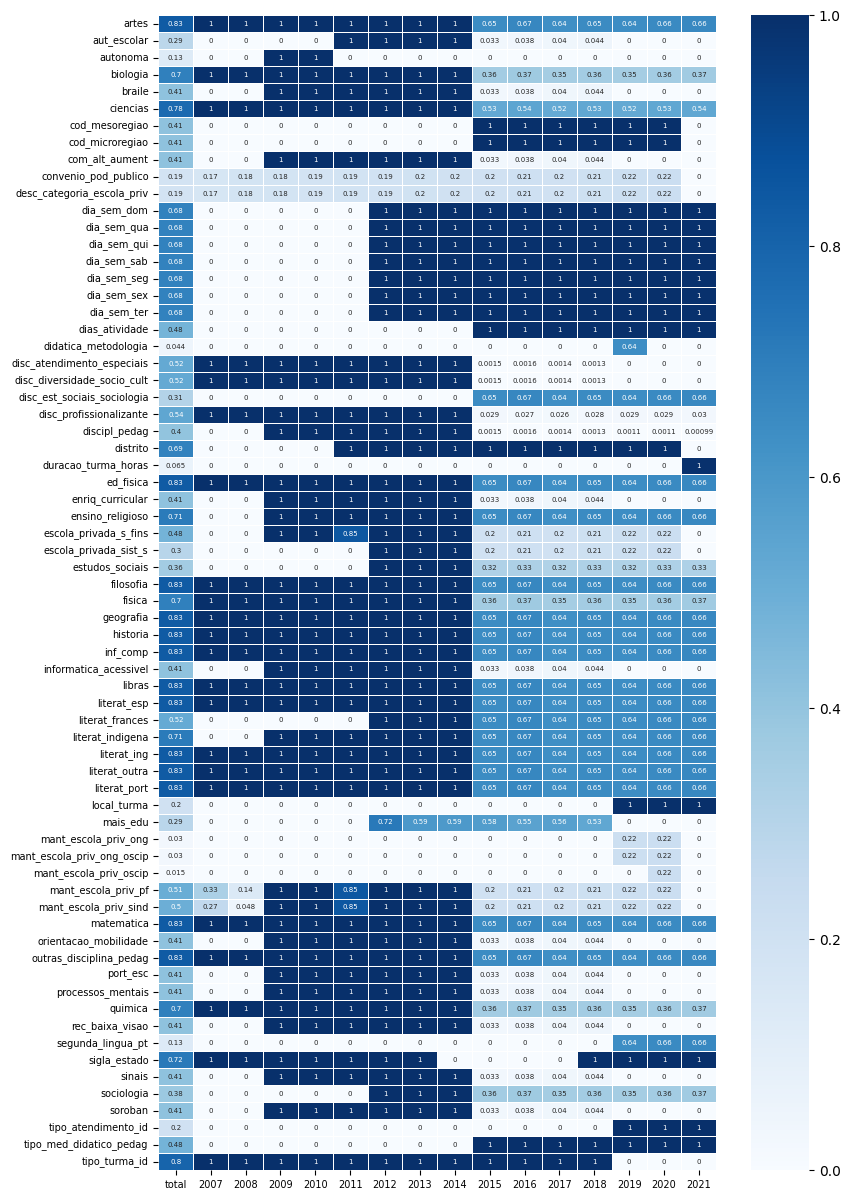

In [9]:
plt.figure(figsize=(9,int(len(interested_df)*0.2)))
plt.yticks(fontsize=7)
plt.xticks(fontsize=7)
sns.heatmap(interested_df_final, cmap='Blues', linewidths=0.5, yticklabels=y_interested_final, annot_kws={'fontsize': 5}, annot=True)
plt.savefig(f'./save_figures/{tabela}_normalizada.png')

In [10]:
print(f'Quantidade de colunas ORIGINAL: {len(norm)}\nQuantidade de colunas interessadas: {len(interested_df_final)}\nColunas removidas: {len(norm) - len(interested_df_final)}')

Quantidade de colunas ORIGINAL: 111
Quantidade de colunas interessadas: 68
Colunas removidas: 43


## 3) Análise da progressão de NULLs

#### Análise da presença média de dados ao longo dos anos

In [11]:
media_anterior = 0
media_atual = 0
y_progressao_total = []
y_media_total = []
x_progressao_total = []
for count, col in enumerate(norm.iloc[:,1:]):
    media_atual = norm[col].mean().round(3)
    print(col, media_atual, (media_atual-media_anterior).round(3))
    x_progressao_total.append(col)
    if(count == 0):
        y_progressao_total.append(0)
    else:
        y_progressao_total.append(media_atual-media_anterior)
    y_media_total.append(media_atual)
    media_anterior = media_atual

2007 0.459 0.459
2008 0.456 -0.003
2009 0.607 0.151
2010 0.607 0.0
2011 0.611 0.004
2012 0.72 0.109
2013 0.719 -0.001
2014 0.71 -0.009
2015 0.504 -0.206
2016 0.509 0.005
2017 0.502 -0.007
2018 0.516 0.014
2019 0.53 0.014
2020 0.529 -0.001
2021 0.457 -0.072


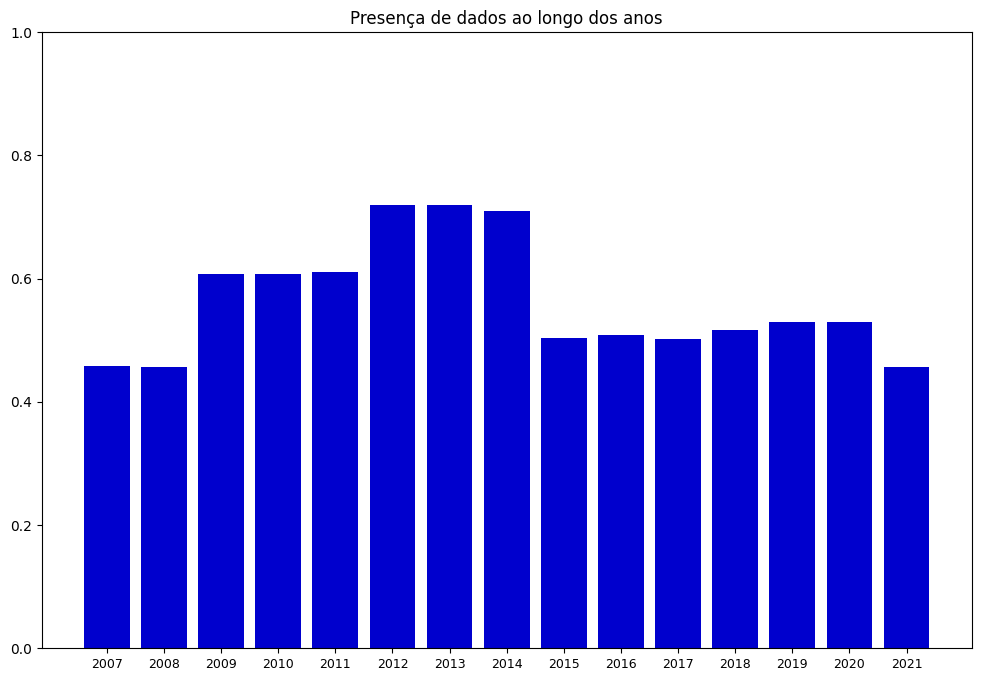

In [12]:
plt.figure(figsize=(12,8))
plt.title('Presença de dados ao longo dos anos')
plt.xticks(fontsize=9)
plt.ylim((0,1))
plt.bar(x_progressao_total, y_media_total, color='mediumblue')
plt.savefig(f'./save_figures/{tabela}_nulls_total.png')

#### Análise das derivadas de dados NULLs ao longo dos anos. Nessa etapa, desconsidera-se dados de colunas que foram descontinuadas, ou seja, que não estão preenchidas em certos anos.

In [13]:
media_anterior = 0
y_progressao = []
y_media = []
x_progressao = []
for count, col in enumerate(interested_df_final.iloc[:,1:]):
    mean = interested_df_final[interested_df_final[col] != 0][col].mean().round(3)
    print(col, mean, (mean-media_anterior).round(3))
    x_progressao.append(col)
    if(count == 0):
        y_progressao.append(0)
    else:
        y_progressao.append(mean-media_anterior)
    y_media.append(mean)
    media_anterior = mean

2007 0.882 0.882
2008 0.867 -0.015
2009 0.96 0.093
2010 0.96 0.0
2011 0.951 -0.009
2012 0.965 0.014
2013 0.963 -0.002
2014 0.962 -0.001
2015 0.49 -0.472
2016 0.499 0.009
2017 0.487 -0.012
2018 0.503 0.016
2019 0.624 0.121
2020 0.622 -0.002
2021 0.698 0.076


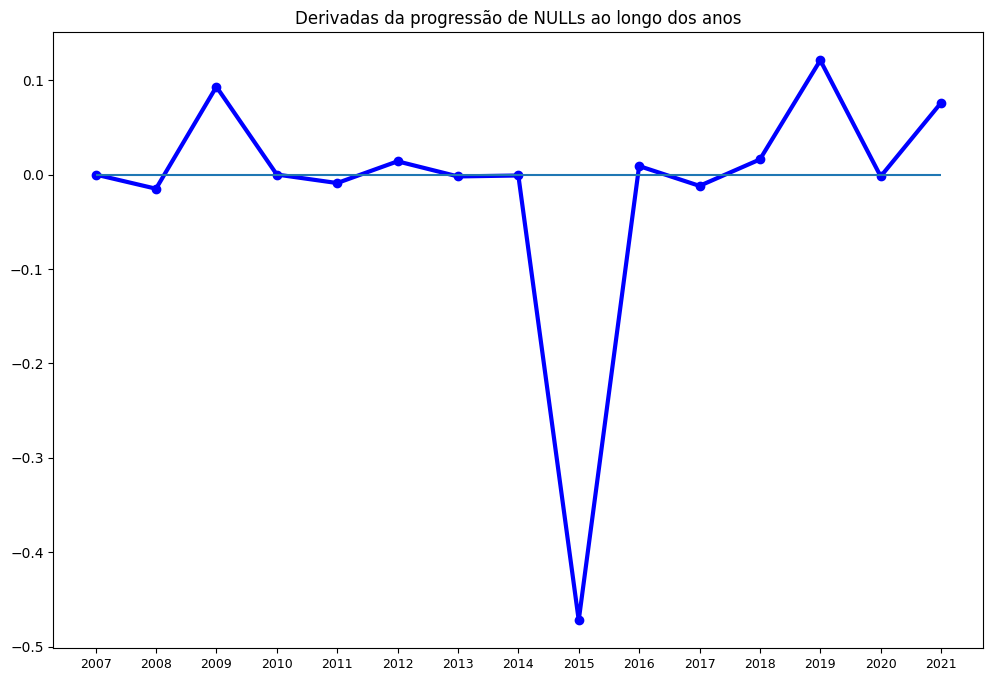

In [14]:
plt.figure(figsize=(12,8))
plt.title('Derivadas da progressão de NULLs ao longo dos anos')
plt.xticks(fontsize=9)
plt.plot(x_progressao, y_progressao, linewidth=3, marker='o', color='blue')
plt.hlines(y=0, xmin='2007', xmax='2021')
plt.savefig(f'./save_figures/{tabela}_derivada.png')

#### Verifica-se que houve uma tendência à progressão da quantidade de dados NULLs ao longo dos anos principalmente no ano de 2015. Em 2020, porém, houve uma retomada da presença de dados no banco do SIMCAQ.

## 4) Alguns insights

#### É possível verificar que algumas colunas adicionadas ao longo dos anos podem ser resultados da falha do mapeamento de certas variáveis, o que influencia na presença de dados NULLs. Um exemplo desse caso é água_potável e água_filtrada.